In [1]:
# plot distribution of area-averaged storm-induced anomalies ont he day of the storm passing and two and four days after
# Fig. 10 in paper (right panels)

In [2]:
import os
from tqdm import tqdm
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from netCDF4 import Dataset, MFDataset
import numba as nb
import time as timing
from numba import njit 
from math import sin, cos, sqrt, atan2, radians
from geopy.distance import distance
import seawater as sw
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)

In [3]:
#---
# SAVEPATH
#---

#---
# where to save plots?
#---
savepath     = '/global/cfs/cdirs/m4003/cnissen/Plots/CESM_storms/composites_1997_2018_subtract_clim_first/'+\
                    'composites_FIXED_DUPLICATES/before_vs_after_storm_passing/'
# check existence of paths
if not os.path.exists(savepath):
    print ('Created '+savepath)
    os.makedirs(savepath)
    
savepath2     = savepath+'eps/'
# check existence of paths
if not os.path.exists(savepath2):
    print ('Created '+savepath2)
    os.makedirs(savepath2)
    
dpicnt = 150
save_plots    = True
display_plots = True


In [4]:
#---
# FUNCTION 
#---

def get_distance_to_storm_center(lat2,lon2,aux_lat,aux_lon):
                
    # create list of locations within 1000km of the storm
    points_data = []
    for pp in range(0,lat2.shape[0]):
        aux = (lat2[pp],lon2[pp])
        points_data.append(aux)
        del aux

    #print(len(points_data))
    # for each of these points get the distance to the storm center in km -> get distance in x-dir and y-dir
    points_distance_x = np.zeros(len(points_data)) # distance in longitudinal direction, i.e., use latitude of storm (aux_lat)
    points_distance_y = np.zeros(len(points_data)) # distance in latitudinal direction, i.e., use longitude of storm (aux_lon)
    for pp in range(0,len(points_data)): 
        # distance in longitudinal direction
        aux_point = (aux_lat,points_data[pp][1])
        points_distance_x[pp] = distance(point_storm, aux_point).km
       # print(aux_point,point_storm,points_distance_x[pp])
        # check sign: if lon grid cell is smaller (=further west) than lon of storm, define distance to be negative
        if points_data[pp][1]<aux_lon:
            points_distance_x[pp] = -1*points_distance_x[pp]
        elif (aux_lon<0) & (points_data[pp][1]>0): # lon_storm is east of dateline, but grid cell is west of dateline (grid cell is also further west in this case!)
            if (points_data[pp][1]-360)<aux_lon:
                points_distance_x[pp] = -1*points_distance_x[pp]
        del aux_point
        # distance in latitudinal direction
        aux_point = (points_data[pp][0],aux_lon)
        points_distance_y[pp] = distance(point_storm, aux_point).km
        # check sign: if lat grid cell is smaller (=further south) than lat of storm, define distance to be negative
        if points_data[pp][0]<aux_lat:
            points_distance_y[pp] = -1*points_distance_y[pp]
        del aux_point  
    return points_distance_x,points_distance_y,points_data
                    
    
def bin_points_as_distance_to_storm_center(counter,points_distance_x,points_distance_y,x_bins,y_bins,aux_data_anom,data_storm_mean,data_storm_std,data_storm_count):
    # data_storm_mean,data_storm_std,data_storm_count: initialized arrays, will be filled in this function and then returned
    
    # bin the points (account for where each point is relative to storm center)
    ind_x = np.digitize(points_distance_x,x_bins,right=False) # minimum is 1 (not zero!!)
    ind_y = np.digitize(points_distance_y,y_bins,right=False)
 #   print(np.min(ind_x),np.max(ind_x))
 #   print(np.min(ind_y),np.max(ind_y))
    # returned index satisfies: bins[i-1] <= x < bins[i]

   # print(aux_data_anom.shape)
    for xx in range(1,len(x_bins)+1): # start at 1 here -> see note above for ind_x
        for yy in range(1,len(x_bins)+1):
            index = np.where((ind_y==yy) & (ind_x==xx))[0]
            if len(index)>0:
                #if counter==6: 
                #    print(xx,yy,index.shape,aux_data_anom.shape)
                #if (counter==40) & (xx==11) & (yy==20):
                #    print(xx,yy,len(points_distance_x))
                #    print(index)
                #    print(index.shape,aux_data_anom.shape)
                # anomaly 2
                data_storm_mean[xx-1,yy-1]  = np.nanmean(aux_data_anom[index])
                data_storm_std[xx-1,yy-1]   = np.nanstd(aux_data_anom[index])
                data_storm_count[xx-1,yy-1] = index.shape[0]
            del index
    return data_storm_mean,data_storm_std,data_storm_count
    
def get_median_ratio(data_storm_aux,data_dev_aux,month_storm_aux,ratio_median,ratio_median_monthly):
    
    # get the median ratio for each year
    counter = 0
    for ss in range(0,data_storm_aux.shape[0]):
        aux_field = 100*(np.nanmean(data_storm_aux[ss,:,:])/np.nanmean(data_dev_aux[ss,:,:]))
        if not np.isnan(aux_field):
            ratio_median[yy] = ratio_median[yy] + aux_field
            counter = counter+1
    ratio_median[yy] = np.divide(ratio_median[yy],counter)
    
    # get the median ratio for each year, EACH MONTH
    for mm in range(0,12):
        ind_mm = np.where(month_storm_aux==mm+1)[0]
        counter = 0
        for ss in ind_mm: 
            aux_field = 100*(np.nanmean(data_storm_aux[ss,:,:])/np.nanmean(data_dev_aux[ss,:,:]))
            if not np.isnan(aux_field):
                ratio_median_monthly[yy,mm] = ratio_median_monthly[yy,mm] + aux_field
                counter = counter+1
        ratio_median_monthly[yy,mm] = np.divide(ratio_median_monthly[yy,mm],counter)
        
    return ratio_median,ratio_median_monthly

def grow_arrays(yy,data_storm_aux,month_storm_aux,day_storm_aux,lat_storm_aux,lon_storm_aux,\
                slp_avg_storm_aux,slp_min_storm_aux,\
                        data_storm,month_storm,day_storm,lat_storm,lon_storm,slp_avg_storm,slp_min_storm,year_storm): 
    if yy==0:
        data_storm  = data_storm_aux
        month_storm = month_storm_aux
        day_storm   = day_storm_aux
        lat_storm   = lat_storm_aux
        lon_storm   = lon_storm_aux
        slp_min_storm   = slp_min_storm_aux
        slp_avg_storm   = slp_avg_storm_aux
        year_storm = year_list[yy]*np.ones(data_storm_aux.shape[0])
    else:
        data_storm  = np.concatenate((data_storm,data_storm_aux))
        month_storm = np.concatenate((month_storm,month_storm_aux))
        day_storm   = np.concatenate((day_storm,day_storm_aux))
        lat_storm   = np.concatenate((lat_storm,lat_storm_aux))
        lon_storm   = np.concatenate((lon_storm,lon_storm_aux))
        slp_min_storm   = np.concatenate((slp_min_storm,slp_min_storm_aux))
        slp_avg_storm   = np.concatenate((slp_avg_storm,slp_avg_storm_aux))
        year_storm  = np.concatenate((year_storm,year_list[yy]*np.ones(data_storm_aux.shape[0])))
                
    return data_storm,month_storm,day_storm,lat_storm,lon_storm,slp_avg_storm,slp_min_storm,year_storm

def load_data(path1a,file1,vari1a): 
    # storm-induced anomaly
    ff  = xr.open_dataset(path1a+file1)
    data_storm_aux  = ff[vari1a].values 
    year_storm_aux  = ff['year_storm'].values  # at min. SLP
    month_storm_aux = ff['month_storm'].values  # at min. SLP
    day_storm_aux   = ff['day_storm'].values  # at min. SLP
    lat_storm_aux   = ff['lat_storm'].values  # at min. SLP
    lon_storm_aux   = ff['lon_storm'].values  # at min. SLP
    slp_avg_storm_aux   = ff['avg_min_slp_storm'].values  # avg of all min SLP over all time steps of the storm's existence 
    slp_min_storm_aux   = ff['min_min_slp_storm'].values  # min. SLP over all time steps of the storm's existence 
    ff.close()
    data_storm_aux[data_storm_aux==0] = np.nan
    
    return data_storm_aux,year_storm_aux,month_storm_aux,day_storm_aux,\
                lat_storm_aux,lon_storm_aux,slp_avg_storm_aux,slp_min_storm_aux


In [5]:
#---
# LOAD DATA
#---

year_list = np.arange(1997,2018+1,1)

def get_statistics(vari_list,time_string_list,year_list): 

    stats_data = np.zeros([3,len(vari_list)], dtype='f16') # 10th perc, median, 90th perc
    for vv in range(0,len(vari_list)):
        vari = vari_list[vv]
        time_string = time_string_list[vv]
        print('Process ',vari,time_string)
        
        # where are data
        path1 = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/'+vari+'_anomalies/'
        path2 = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/'+vari+'_emulator_anomalies/'
        path3 = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/'+vari+'_hr_anomalies/'

        # if vari is not totChl, provide path to totChl (LOW RES, full & emulator) here --> files need to be loaded so that strongest storms can be identified correctly
        path_chl    = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/totChl_anomalies/'
        path_chl_em = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/totChl_emulator_anomalies/'

        #----
        # LOW RES, FULL FIELD
        #----

        # storm-induced anomaly
        file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_'+vari+'_'+\
                    str(year_list[0])+'_'+str(year_list[-1])+time_string+'_subtract_clim_first.nc'
        file1b = 'Composite_abs_field_within_1000km_of_storm_center_at_noon_'+vari+'_'+\
                    str(year_list[0])+'_'+str(year_list[-1])+time_string+'_subtract_clim_first.nc'

        # load data
        data_storm,year_storm,month_storm,day_storm,lat_storm,\
                    lon_storm,slp_avg_storm,slp_min_storm = load_data(path1,file1,vari+'_storm_anomaly4_mean')
       
        # avg for each storm first, then average over all
        ratio = np.zeros([data_storm.shape[0]])
        for tt in range(0,data_storm.shape[0]):
            ratio[tt] = np.nanmean(data_storm[tt,:,:])

        factor = 10000
        stats_data[0,vv] = np.round(factor*np.nanpercentile(ratio,10))/factor
        stats_data[1,vv] = np.round(factor*np.nanmedian(ratio))/factor
        stats_data[2,vv] = np.round(factor*np.nanpercentile(ratio,90))/factor
        
        #del data_storm,month_storm,day_storm,year_storm,lat_storm,lon_storm,slp_avg_storm,slp_min_storm #,data_storm_abs

    return stats_data
        

vari_list = ['totChl_emulator','totChl_emulator','totChl_emulator']#,'totChl_emulator']
time_string_list = ['','_plus_2_days','_plus_4_days'] # '_minus_2_days',
stats_data_chl_em = get_statistics(vari_list,time_string_list,year_list)
print(stats_data_chl_em)

vari_list = ['totChl','totChl','totChl']#,'totChl']
time_string_list = ['','_plus_2_days','_plus_4_days'] # '_minus_2_days',
stats_data_chl = get_statistics(vari_list,time_string_list,year_list)
print(stats_data_chl)

vari_list = ['photoC_zint','photoC_zint','photoC_zint']#,'photoC_zint']
time_string_list = ['','_plus_2_days','_plus_4_days'] # '_minus_2_days',
stats_data_npp   = get_statistics(vari_list,time_string_list,year_list)
stats_data_npp = stats_data_npp*86400*0.01 # convert from mmol m-3 cm s-1  to  mmol m-2 d-1
print(stats_data_npp)

vari_list = ['MLD','MLD','MLD']#,'MLD']
time_string_list = ['','_plus_2_days','_plus_4_days'] # '_minus_2_days',
stats_data_mld = get_statistics(vari_list,time_string_list,year_list)
stats_data_mld = stats_data_mld*0.01 # convert to m
print(stats_data_mld)

vari_list = ['PAR_incoming','PAR_incoming','PAR_incoming']
time_string_list = ['','_plus_2_days','_plus_4_days'] # '_minus_2_days',
stats_data_par = get_statistics(vari_list,time_string_list,year_list)
print(stats_data_par)

vari_list = ['wind_speed','wind_speed','wind_speed']
time_string_list = ['','_plus_2_days','_plus_4_days'] # '_minus_2_days',
stats_data_wind = get_statistics(vari_list,time_string_list,year_list)
print(stats_data_wind)


Process  totChl_emulator 


/tmp/ipykernel_80232/2604207108.py:41: RuntimeWarning: Mean of empty slice
  ratio[tt] = np.nanmean(data_storm[tt,:,:])


Process  totChl_emulator _plus_2_days
Process  totChl_emulator _plus_4_days
[[-5.640e-02 -1.027e-01 -1.343e-01]
 [-1.000e-04 -2.600e-03 -3.100e-03]
 [ 4.800e-02  5.220e-02  6.980e-02]]
Process  totChl 
Process  totChl _plus_2_days
Process  totChl _plus_4_days
[[-0.0319 -0.0646 -0.0803]
 [-0.0001 -0.0007 -0.0008]
 [ 0.0275  0.0281  0.0394]]
Process  photoC_zint 
Process  photoC_zint _plus_2_days
Process  photoC_zint _plus_4_days
[[-2.592  -2.2464 -3.2832]
 [-0.0864  0.     -0.    ]
 [ 0.7776  2.16    2.3328]]
Process  MLD 
Process  MLD _plus_2_days
Process  MLD _plus_4_days
[[-5.472402 -4.395044 -5.060312]
 [-0.063951  0.978632  1.211461]
 [ 4.468782  9.084923 10.968469]]
Process  PAR_incoming 
Process  PAR_incoming _plus_2_days
Process  PAR_incoming _plus_4_days
[[-8.8653 -3.3554 -4.5832]
 [-0.6527  0.8398  0.4462]
 [ 2.675   8.21    7.1496]]
Process  wind_speed 
Process  wind_speed _plus_2_days
Process  wind_speed _plus_4_days
[[-1.1782 -1.9272 -1.9836]
 [ 0.5725 -0.0519  0.0388]
 [ 2

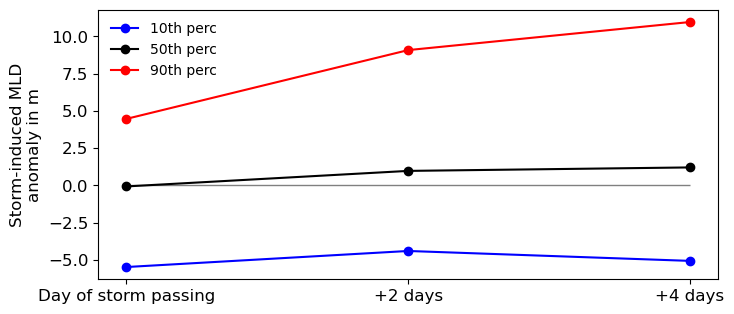

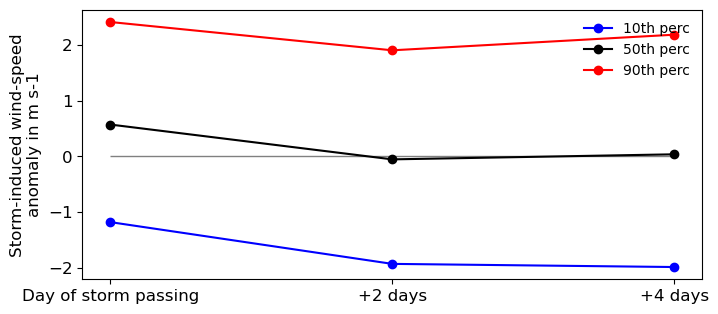

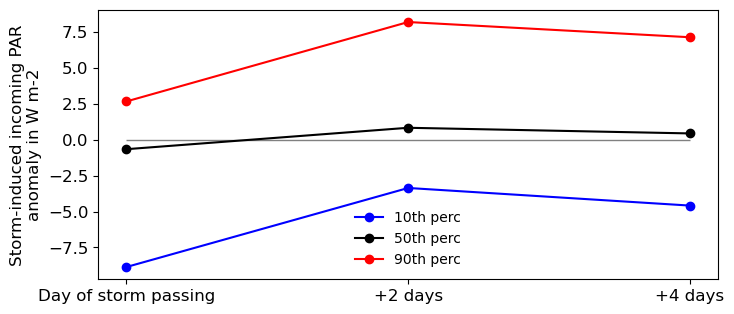

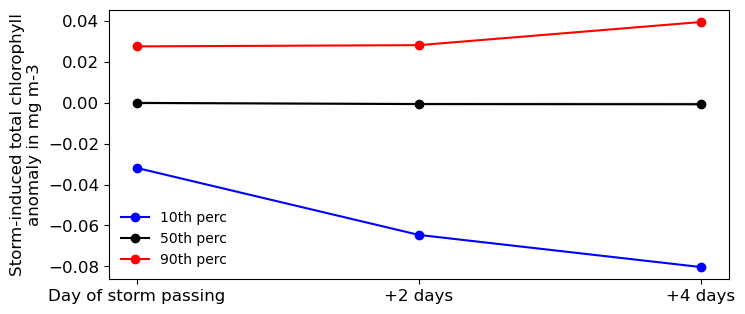

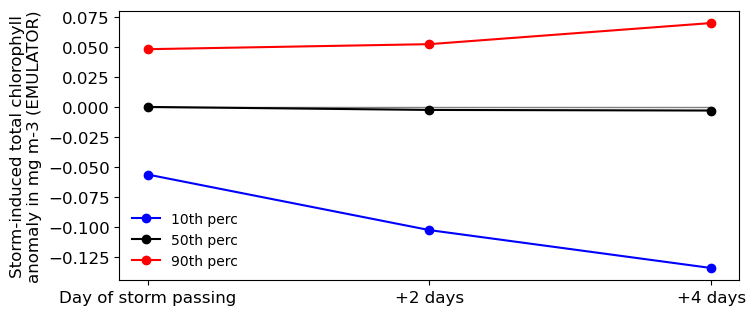

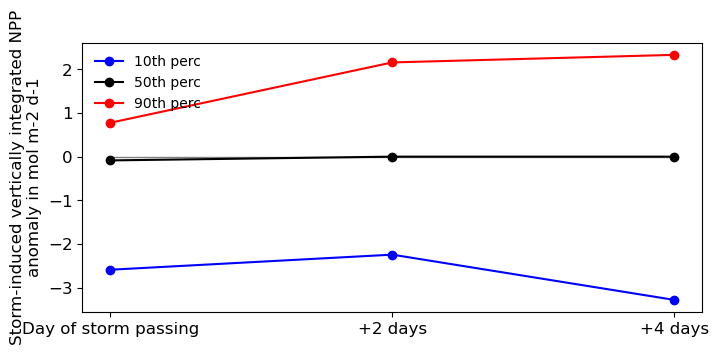

In [6]:
#---
# PLOT
#---

fs = 12
dpicnt = 200

save_plots    = True
display_plots = True

vari_list = ['MLD','wind_speed','incoming_PAR','totChl','totChl_emulator','photoC_zint']

for vv in range(0,len(vari_list)):
    vari = vari_list[vv]

    if vari=='MLD':
        stats_to_plot = np.copy(stats_data_mld) # percentiles x time_strings
        ylabel_string = 'Storm-induced MLD\nanomaly in m'
    elif vari=='wind_speed':
        stats_to_plot = np.copy(stats_data_wind) # percentiles x time_strings
        ylabel_string = 'Storm-induced wind-speed\nanomaly in m s-1'
    elif vari=='incoming_PAR':
        stats_to_plot = np.copy(stats_data_par) # percentiles x time_strings
        ylabel_string = 'Storm-induced incoming PAR\nanomaly in W m-2'
    elif vari=='totChl':
        stats_to_plot = np.copy(stats_data_chl) # percentiles x time_strings
        ylabel_string = 'Storm-induced total chlorophyll\nanomaly in mg m-3'
    elif vari=='totChl_emulator':
        stats_to_plot = np.copy(stats_data_chl_em) # percentiles x time_strings
        ylabel_string = 'Storm-induced total chlorophyll\nanomaly in mg m-3 (EMULATOR)'
    elif vari=='photoC_zint':
        stats_to_plot = np.copy(stats_data_npp) # percentiles x time_strings
        ylabel_string = 'Storm-induced vertically integrated NPP\nanomaly in mol m-2 d-1'

    # one color per percentile
    percentile_list = ['10th perc','50th perc','90th perc']
    color_list = ['b','k','r']

    if stats_to_plot.shape[1]==4: 
        time_string_list = ['-2 days','Day of storm passing','+2 days','+4 days']
    else:
        #time_string_list = ['-2 days','Day of storm passing','+2 days']
        time_string_list = ['Day of storm passing','+2 days','+4 days']

    fig=plt.figure(figsize=(8,3.5))
    plt.hlines(0,0,len(time_string_list)-1,color='grey',linewidth=1)
    for tt in range(0,len(percentile_list)):
        plt.plot(stats_to_plot[tt,:],'o',linestyle='-',color=color_list[tt],label=percentile_list[tt]) 
    plt.xticks(np.arange(0,len(time_string_list)),time_string_list,fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.legend(frameon=False)
    plt.ylabel(ylabel_string,fontsize=fs)
    if save_plots:
        filename = 'Average_anomaly_over_time_LOW_RES_full_field_'+vari+'.png'
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)


MLD
Day of
storm passing
90th perc 4.4687820000000000186
50th perc -0.06395100000000000362
10th perc -5.472401999999999703
+2
days
90th perc 9.084923000000000191
50th perc 0.97863200000000008223
10th perc -4.3950439999999998467
+4
days
90th perc 10.968469000000000279
50th perc 1.2114610000000000663
10th perc -5.060312000000000231


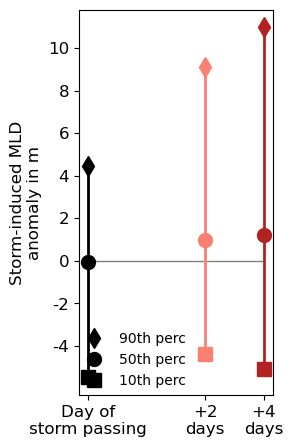

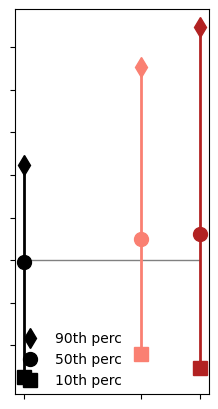

totChl
Day of
storm passing
90th perc 0.027500000000000000139
50th perc -0.00010000000000000000479
10th perc -0.031899999999999997802
+2
days
90th perc 0.028099999999999999978
50th perc -0.0006999999999999999929
10th perc -0.06460000000000000464
+4
days
90th perc 0.039399999999999997524
50th perc -0.00080000000000000003834
10th perc -0.08029999999999999638


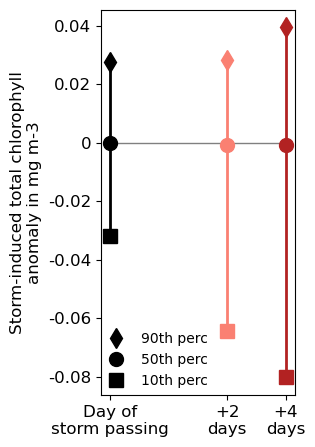

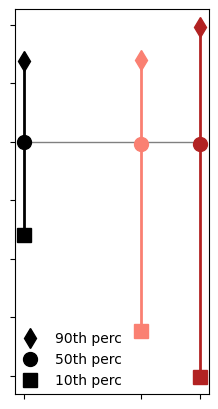

totChl_emulator
Day of
storm passing
90th perc 0.048000000000000001
50th perc -0.00010000000000000000479
10th perc -0.056399999999999998745
+2
days
90th perc 0.052200000000000003342
50th perc -0.0025999999999999998807
10th perc -0.10269999999999999962
+4
days
90th perc 0.06980000000000000093
50th perc -0.003099999999999999891
10th perc -0.13430000000000000271


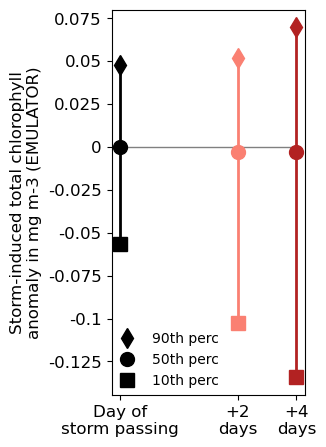

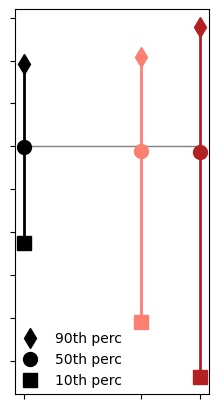

photoC_zint
Day of
storm passing
90th perc 0.7775999999999999949
50th perc -0.086400000000000005936
10th perc -2.592000000000000108
+2
days
90th perc 2.1600000000000000899
50th perc 0.0
10th perc -2.2463999999999999437
+4
days
90th perc 2.332800000000000172
50th perc -0.0
10th perc -3.2832000000000000617


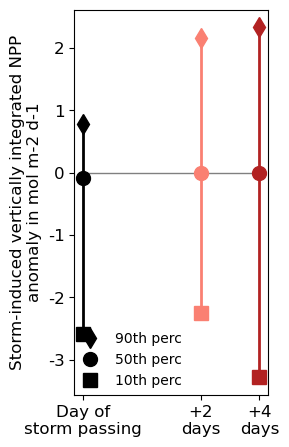

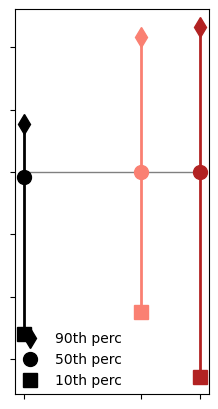

In [7]:
#---
# PLOT
#---

fs = 12
dpicnt = 200

save_plots    = True
display_plots = True
plot_eps = True

vari_list = ['MLD','wind_speed','incoming_PAR','totChl','totChl_emulator','photoC_zint']

for vv in [0,3,4,5]: #range(5,6):#0,len(vari_list)):
    vari = vari_list[vv]

    if vari=='MLD':
        stats_to_plot = np.copy(stats_data_mld) # percentiles x time_strings
        ylabel_string = 'Storm-induced MLD\nanomaly in m'
        yticks = [-4,-2,0,2,4,6,8,10]
        yticklabels = yticks
    elif vari=='wind_speed':
        stats_to_plot = np.copy(stats_data_wind) # percentiles x time_strings
        ylabel_string = 'Storm-induced wind-speed\nanomaly in m s-1'
    elif vari=='incoming_PAR':
        stats_to_plot = np.copy(stats_data_par) # percentiles x time_strings
        ylabel_string = 'Storm-induced incoming PAR\nanomaly in W m-2'
    elif vari=='totChl':
        stats_to_plot = np.copy(stats_data_chl) # percentiles x time_strings
        ylabel_string = 'Storm-induced total chlorophyll\nanomaly in mg m-3'
        yticks = [-0.08,-0.06,-0.04,-0.02,0,0.02,0.04]
        yticklabels = yticks
    elif vari=='totChl_emulator':
        stats_to_plot = np.copy(stats_data_chl_em) # percentiles x time_strings
        ylabel_string = 'Storm-induced total chlorophyll\nanomaly in mg m-3 (EMULATOR)'
        yticks = [-0.125,-0.1,-0.075,-0.05,-0.025,0,0.025,0.05,0.075]
        yticklabels = ['',-0.1,'',-0.05,'',0,'',0.05,'']
    elif vari=='photoC_zint':
        stats_to_plot = np.copy(stats_data_npp) # percentiles x time_strings
        ylabel_string = 'Storm-induced vertically integrated NPP\nanomaly in mol m-2 d-1'
        yticks = [-3,-2,-1,0,1,2]
        yticklabels = yticks

    # one color per percentile
    percentile_list = ['10th perc','50th perc','90th perc']
    color_list = ['k','salmon','firebrick'] # 'b',

    if stats_to_plot.shape[1]==4: 
        time_string_list = ['-2 days','Day of storm passing','+2 days','+4 days']
    else:
        #time_string_list = ['-2 days','Day of storm passing','+2 days']
        time_string_list = ['Day of\nstorm passing','+2\ndays','+4\ndays']

    xticks = [0,1,1.5]#,2]
    
    print(vari)
    ms = 10
    
    fig=plt.figure(figsize=(2.5,5))
    plt.hlines(0,xticks[0],xticks[-1],color='grey',linewidth=1)
    for tt in range(0,len(time_string_list)):
        print(time_string_list[tt])
        print(percentile_list[2],stats_to_plot[2,tt])
        print(percentile_list[1],stats_to_plot[1,tt])
        print(percentile_list[0],stats_to_plot[0,tt])
        if tt==0:
            plt.plot(xticks[tt],stats_to_plot[2,tt],'d',color=color_list[tt],markersize=ms,label=percentile_list[2])  #linestyle='-',
            plt.plot(xticks[tt],stats_to_plot[1,tt],'o',color=color_list[tt],markersize=ms,label=percentile_list[1]) 
            plt.plot(xticks[tt],stats_to_plot[0,tt],'s',color=color_list[tt],markersize=ms,label=percentile_list[0])
        else:
            plt.plot(xticks[tt],stats_to_plot[2,tt],'d',color=color_list[tt],markersize=ms)  #linestyle='-',
            plt.plot(xticks[tt],stats_to_plot[1,tt],'o',color=color_list[tt],markersize=ms) 
            plt.plot(xticks[tt],stats_to_plot[0,tt],'s',color=color_list[tt],markersize=ms)
        plt.vlines(xticks[tt],np.min(stats_to_plot[:,tt]),np.max(stats_to_plot[:,tt]),linewidth=2,color=color_list[tt])
    plt.xticks(xticks,time_string_list,fontsize=fs)
    plt.yticks(yticks,yticks,fontsize=fs)
    plt.legend(loc='center',bbox_to_anchor=(0.28,0.09),frameon=False,\
               ncol=1,fancybox=False,shadow=False,prop={'size':10})
    plt.ylabel(ylabel_string,fontsize=fs)
    if save_plots:
        filename = 'Average_anomaly_over_time_LOW_RES_full_field_'+vari+'_v2.png'
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)
        
    if plot_eps:
        fig=plt.figure(figsize=(2.5,5))
        plt.hlines(0,xticks[0],xticks[-1],color='grey',linewidth=1)
        for tt in range(0,len(time_string_list)):
            if tt==0:
                plt.plot(xticks[tt],stats_to_plot[2,tt],'d',color=color_list[tt],markersize=ms,label=percentile_list[2])  #linestyle='-',
                plt.plot(xticks[tt],stats_to_plot[1,tt],'o',color=color_list[tt],markersize=ms,label=percentile_list[1]) 
                plt.plot(xticks[tt],stats_to_plot[0,tt],'s',color=color_list[tt],markersize=ms,label=percentile_list[0])
            else:
                plt.plot(xticks[tt],stats_to_plot[2,tt],'d',color=color_list[tt],markersize=ms)  #linestyle='-',
                plt.plot(xticks[tt],stats_to_plot[1,tt],'o',color=color_list[tt],markersize=ms) 
                plt.plot(xticks[tt],stats_to_plot[0,tt],'s',color=color_list[tt],markersize=ms)
            plt.vlines(xticks[tt],np.min(stats_to_plot[:,tt]),np.max(stats_to_plot[:,tt]),linewidth=2,color=color_list[tt])
        plt.xticks(xticks,[],fontsize=fs)
        plt.yticks(yticks,[],fontsize=fs)
        plt.legend(loc='center',bbox_to_anchor=(0.28,0.09),frameon=False,\
                   ncol=1,fancybox=False,shadow=False,prop={'size':10})
        if save_plots:
            filename = 'Average_anomaly_over_time_LOW_RES_full_field_'+vari+'_v2.eps'
            plt.savefig(savepath2+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
        if display_plots:
            plt.show()
        else:
            plt.close(fig)


In [8]:
print(savepath)

/global/cfs/cdirs/m4003/cnissen/Plots/CESM_storms/composites_1997_2018_subtract_clim_first/composites_FIXED_DUPLICATES/before_vs_after_storm_passing/
